<a href="https://colab.research.google.com/github/jblanco89/ML-Zoomcamp-course/blob/main/LogisticRegressionPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression Practice

## HCV data

Dataset: https://archive.ics.uci.edu/dataset/571/hcv+data

The data set contains laboratory values of blood donors and Hepatitis C patients and demographic values like age.
The target attribute for classification is Category:

{'0=Blood Donor', '0=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'}


In [ ]:
# Import libraries
import pandas as pd
import numpy as np

### Upload data from UCI repository

In [ ]:
hcv_data = pd.read_csv('/content/drive/MyDrive/ML-Zoomcamp-2023/hcvdat0.csv',
                       sep=',', index_col=0)
hcv_data.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


### Category transformation

Due to multinomial classification is not covered in this post, we need to transform multiclass variable (`Category`) in binomial class (0,1).
Hence, `Blodd Donor` and `suspect Blood Donor` are going to set as `1`, and the other categories as `0` (`Hepatitis`, `Fibrosis`, `Cirrhosis`)

**Notice:** Exploratory Data Analysis step has been skipped in this time to make this article shorter. To check data quality of dataset is mandatory anyway.

<Axes: xlabel='Category'>

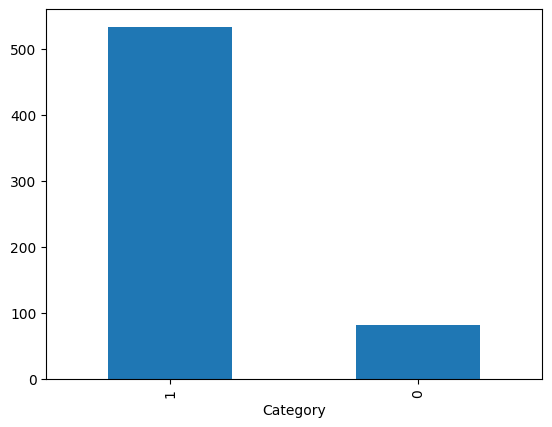

In [ ]:
hcv_data['Category'] = [(1 if category == '0=Blood Donor' or category =='0=suspect Blood Donor' else 0) for category in hcv_data['Category']]
count_cat = hcv_data['Category'].value_counts().reset_index()
count_cat.columns = ['Category', 'Count']
count_cat.plot(kind='bar', x='Category', y='Count', legend=False)


As you can see, we have imbalanced class. In these cases resampling methods (Oversampling or Undesampling) are tipically used to handle this, but it won't be covered in this article.

In [ ]:
hcv_df = hcv_data.copy()
hcv_df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,1,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,1,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,1,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,1,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## Atributes explanation:
Based on [Hoffmann et al.(2018)](https://jlpm.amegroups.org/article/view/4401/5425) paper, we are going to consider the same variable as they used, which are:

* Category: 1= Blood Donor or suspect of Blood Donor
* Age: Patient age in years
* Sex: patient sex, m=0, f=1
* ALB: albumin levels (Continuous)
* BIL: bilirubin levels (Continuous)
* CHE: choline esterase levels (Continuous)
* GGT: γ-glutamyl-transferase levels (Continuous)
* AST: aspartate amino-transferase levels (Continuous)
* ALT: alanine amino-transferase levels



## Dataset preparation

Now, we are going to select features of dataset and double check missing values in it. If it so, it will be filled with mean of the column values.

In [ ]:
hcv_df = hcv_df[['ALB', 'BIL', 'CHE', 'GGT', 'AST', 'ALT', 'Category']]
hcv_df.isna().sum()

ALB         1
BIL         0
CHE         0
GGT         0
AST         0
ALT         1
Category    0
dtype: int64

In [ ]:
hcv_df['ALB'] = hcv_df['ALB'].fillna(hcv_df['ALB'].mean())
hcv_df['ALT'] = hcv_df['ALT'].fillna(hcv_df['ALT'].mean())

In [ ]:
hcv_df.isna().sum()

ALB         0
BIL         0
CHE         0
GGT         0
AST         0
ALT         0
Category    0
dtype: int64

In [ ]:
hcv_df.head()

,ALB,BIL,CHE,GGT,AST,ALT,Category
1,38.5,7.5,6.93,12.1,22.1,7.7,1
2,38.5,3.9,11.17,15.6,24.7,18.0,1
3,46.9,6.1,8.84,33.2,52.6,36.2,1
4,43.2,18.9,7.33,33.8,22.6,30.6,1
5,39.2,9.6,9.15,29.9,24.8,32.6,1


## Split dataset
Train: 60%

validation: 20%

Test: 20%


In [ ]:
def split_dataset(df, target_name, train_prop, val_prop, test_prop, random_state):
  df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
  y = df[target_name]
  X = df.drop(columns=target_name,axis=1)

  train_indexes = int(len(df)*train_prop)
  val_indexes = int(len(df)*val_prop)

  X_train = X[:train_indexes]
  X_val = X[train_indexes:train_indexes + val_indexes]
  X_test = X[train_indexes + val_indexes:]

  y_train = y[:train_indexes]
  y_val = y[train_indexes:train_indexes + val_indexes]
  y_test = y[train_indexes + val_indexes:]

  data_splitted = [X_train, y_train, X_val, y_val, X_test, y_test]
  return data_splitted



In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(hcv_df,
                                                               target_name='Category',
                                                               train_prop=0.6,
                                                               val_prop=0.2,
                                                               test_prop=0.2,
                                                               random_state=42)


## Logistic Regression Model

X: Features

y: target

$X = \begin{bmatrix}
w0 & ALB & BIL & CHE & GGT & AST & ALT \\
1 & 38.5 & 7.5 & 6.93 & 12.1 & 22.1 & 7.7 \\
1 & 38.5 & 3.9 & 11.17 & 15.6 & 24.7 & 18.0 \\
1 & 46.9 & 6.1 & 8.84 & 33.2 & 52.6 & 36.2 \\
1 & 43.2 & 18.9 & 7.33 & 33.8 & 22.6 & 30.6	\\
... & ... & ... & ... & ... & ... & ...
\end{bmatrix}$




$y = \begin{bmatrix}
category\\
1\\
1\\
1\\
1\\
...
\end{bmatrix}$


$W = \begin{bmatrix}
weights\\
0\\
0\\
0\\
0\\
...
\end{bmatrix}$

First, we need to add $W_0$ values to feature matrix in our dataset. Secondly, train the model using Normal Equation approach, and then, validate model performance with validation data using cost functio formula. Let's set the functions will be needed.



In [ ]:
X_train.shape

(369, 6)

In [ ]:
X_train_stacked = pd.concat([pd.Series(1, index=X_train.index, name='W0'), X_train], axis=1)
X_train_stacked.head()

,W0,ALB,BIL,CHE,GGT,AST,ALT
0,1,28.1,2.8,5.58,26.2,17.5,16.6
1,1,31.4,2.4,5.95,22.9,17.0,16.6
2,1,43.7,8.1,8.15,13.4,26.3,17.3
3,1,32.0,50.0,5.57,650.9,110.3,5.9
4,1,35.5,6.4,8.81,24.1,29.5,27.5


$$W = (X^{T} * X)^{-1} * X^{T} * y^T$$

In [ ]:
X = np.matrix(X_train_stacked)
y = np.matrix(y_train).T

In [ ]:
W = np.linalg.inv(X.T*X) * X.T * y
W

matrix([[ 8.58051212e-01],
        [ 6.97079801e-03],
        [-2.24239344e-03],
        [-1.55449883e-03],
        [-1.40208916e-03],
        [-6.10794657e-03],
        [ 2.60820872e-04]])

In [ ]:
y_pred = 1 / (1 + np.exp(-(X * W)))
y_pred.shape

(369, 1)

We need to check model performance:


In [ ]:
#cost function
m = len(y)
J = (-1/m)*(y.T*np.log(y_pred) + (1 - y).T * np.log(1 - y_pred))
J = J[0,0]
J

0.4239741479137652

cost `42,39%`

Let's validate performance model with validation data


In [ ]:
def logistic_regression(X, W, y):
  X = pd.concat([pd.Series(1, index=X.index, name='W0'), X], axis=1)
  X = np.matrix(X)
  y = np.matrix(y).T
  y_pred = 1 / (1 + np.exp(-(X * W)))
  m = len(y)
  J = (-1/m)*(y.T*np.log(y_pred) + (1 - y).T * np.log(1 - y_pred))
  J = J[0,0]
  return y_pred, J


In [ ]:
y_pred, cost_value = logistic_regression(X=X_val, W=W, y=y_val)
cost_value

0.40020112123111873

Now, let's combine train with val and we are going to test the model:


In [ ]:
X_all = pd.concat([X_train, X_val, X_test], axis=0)
y_all = pd.concat([y_train, y_val, y_test], axis=0)


In [ ]:
y_pred, cost_value = logistic_regression(X=X_all, W=W, y=y_all)
cost_value

0.41296291766492854

Now, we need to find the accuracy of the model:

In [ ]:
y_test_pred, cost_value = logistic_regression(X=X_test, W=W, y=y_test)
y_test_pred = np.array([1 if value >= 0.5 else 0 for value in y_test_pred])

In [ ]:
y_test = np.array(y_test)

In [ ]:
k = np.double(y_test_pred == np.array(y_test))
acc = np.mean(k)*100
acc

91.05691056910568

Accuracy of `91.05%`

